# 비트코인 상승장 vs 하락장 워드클라우드 분석

## 분석 목표
- 상승장(2025-10-01 ~ 2025-10-05)과 하락장(2025-10-06 ~ 2025-10-11)의 소셜미디어 텍스트를 분석
- 각 기간의 top 100 단어 중 교집합을 stopwords로 제거
- 상승장은 빨간색, 하락장은 파란색 테마로 워드클라우드 생성

In [1]:
# ============================================================
# 셀 1: 라이브러리 import 및 기본 설정
# ============================================================

# 데이터 처리를 위한 기본 라이브러리
import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings

# 시각화 라이브러리
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 경고 메시지 무시 (데이터 처리 중 발생하는 불필요한 경고 제거)
warnings.filterwarnings('ignore')

# Jupyter Notebook에서 그래프를 인라인으로 표시
%matplotlib inline

# pandas 출력 옵션 설정
pd.set_option('display.max_columns', None)  # 모든 컬럼 표시
pd.set_option('display.max_rows', 100)      # 최대 100행까지 표시

print("✅ 모든 라이브러리가 성공적으로 로드되었습니다.")
print(f"pandas 버전: {pd.__version__}")
print(f"numpy 버전: {np.__version__}")

Matplotlib is building the font cache; this may take a moment.


✅ 모든 라이브러리가 성공적으로 로드되었습니다.
pandas 버전: 3.0.0
numpy 버전: 2.4.1


In [2]:
# ============================================================
# 셀 2: CSV 로드 및 컬럼 확인
# ============================================================

# CSV 파일 경로 설정
file_path = r'data\processed\SNS_Youtube_data\FINAL_SNS_YOUTUBE.csv'

print("📂 데이터 파일 로드 중...")
print(f"파일 경로: {file_path}\n")

# STD_DATE를 문자열로 강제 지정 (pandas가 자동으로 datetime 파싱하는 것 방지)
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False, dtype={'STD_DATE': str})
print(f"✅ 데이터 로드 성공! 총 {len(df):,}개의 행이 로드되었습니다.\n")

# 데이터 미리보기 (처음 5행)
print("📊 데이터 미리보기 (처음 5행):")
print("="*80)
display(df.head())

# 컬럼 목록 출력
print("\n📋 컬럼 목록:")
print("="*80)
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col} (타입: {df[col].dtype})")

# 텍스트 컬럼과 날짜 컬럼 지정
text_col = 'content'
date_col = 'STD_DATE'

print(f"\n✅ 사용할 컬럼:")
print(f"   텍스트 컬럼: {text_col}")
print(f"   날짜 컬럼: {date_col}")

# 컬럼 존재 여부 확인
if text_col not in df.columns:
    raise ValueError(f"❌ '{text_col}' 컬럼을 찾을 수 없습니다.")
if date_col not in df.columns:
    raise ValueError(f"❌ '{date_col}' 컬럼을 찾을 수 없습니다.")

📂 데이터 파일 로드 중...
파일 경로: data\processed\SNS_Youtube_data\FINAL_SNS_YOUTUBE.csv

✅ 데이터 로드 성공! 총 6,382개의 행이 로드되었습니다.

📊 데이터 미리보기 (처음 5행):


,STD_DATE,platform,type,content,engagement,author,url,original_date,id
0,20250901,YouTube,video,Why I Sold 500000 Of Bitcoin BTC Crypto Crash ...,6880,Gerhard - Bitcoin Strategy,https://www.youtube.com/watch?v=RN1CTwBj2uU,2025-09-01T10:29:21Z,RN1CTwBj2uU
1,20250901,YouTube,video,Everyone is panic selling but you39re buying t...,114,Market Breathing,https://www.youtube.com/watch?v=xgJTcP3mho8,2025-09-01T04:01:08Z,xgJTcP3mho8
2,20250901,YouTube,comment,This dude is a different kind of special Shows...,13,@7Investments,https://www.youtube.com/watch?v=RN1CTwBj2uU,2025-09-01T14:47:19Z,UgykocZ3jTDbwjy_f5V4AaABAg
3,20250901,YouTube,comment,Everyone falling for the September scare see y...,8,@stavrosgreen4143,https://www.youtube.com/watch?v=RN1CTwBj2uU,2025-09-01T11:28:26Z,UgxYDuOGpzA_y6GTTnl4AaABAg
4,20250901,YouTube,comment,Theres a solid chance you just sold near the b...,6,@1stCommentChillin,https://www.youtube.com/watch?v=RN1CTwBj2uU,2025-09-01T17:22:22Z,Ugw1H9cpqadd6fwSG3h4AaABAg



📋 컬럼 목록:
  1. STD_DATE (타입: str)
  2. platform (타입: str)
  3. type (타입: str)
  4. content (타입: str)
  5. engagement (타입: int64)
  6. author (타입: str)
  7. url (타입: str)
  8. original_date (타입: str)
  9. id (타입: str)

✅ 사용할 컬럼:
   텍스트 컬럼: content
   날짜 컬럼: STD_DATE


In [3]:
# ============================================================
# 셀 3: 날짜 전처리 및 기간 필터링
# ============================================================

print("📅 날짜 데이터 전처리 시작...\n")

# 날짜 컬럼을 pandas datetime 형식으로 변환
# format='%Y%m%d'로 YYYYMMDD 형식 (예: 20251001) 지정
# errors='coerce'로 변환 불가능한 값은 NaT로 처리
print(f"날짜 데이터 샘플 (변환 전): {df[date_col].head(3).tolist()}")

df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d', errors='coerce')

print(f"날짜 데이터 샘플 (변환 후): {df[date_col].head(3).tolist()}")

# 날짜가 없는 행 제거
invalid_dates = df[date_col].isna().sum()
if invalid_dates > 0:
    print(f"⚠️ 날짜가 없는 {invalid_dates:,}개 행을 제거합니다.")
    df = df.dropna(subset=[date_col])

# 전체 데이터 날짜 범위 확인
print(f"\n전체 데이터 날짜 범위:")
print(f"  최소 날짜: {df[date_col].min()}")
print(f"  최대 날짜: {df[date_col].max()}")

# ============================================================
# 상승장/하락장 기간 설정 및 필터링
# ============================================================

# 상승장: 2025-10-01 ~ 2025-10-05
bull_start = pd.Timestamp('2025-10-01')
bull_end = pd.Timestamp('2025-10-05 23:59:59')

# 하락장: 2025-10-06 ~ 2025-10-11
bear_start = pd.Timestamp('2025-10-06')
bear_end = pd.Timestamp('2025-10-11 23:59:59')

print(f"\n📈 상승장 기간: {bull_start.date()} ~ {bull_end.date()}")
print(f"📉 하락장 기간: {bear_start.date()} ~ {bear_end.date()}")

# 기간별 데이터 필터링
df_up = df[(df[date_col] >= bull_start) & (df[date_col] <= bull_end)].copy()
df_down = df[(df[date_col] >= bear_start) & (df[date_col] <= bear_end)].copy()

print(f"\n✅ 필터링 완료:")
print(f"   상승장 데이터: {len(df_up):,}개 행")
print(f"   하락장 데이터: {len(df_down):,}개 행")

# 일별 분포 확인
print(f"\n일별 데이터 분포:")
print(f"\n[상승장]")
for date, count in df_up.groupby(df_up[date_col].dt.date).size().items():
    print(f"  {date}: {count:,}개")

print(f"\n[하락장]")
for date, count in df_down.groupby(df_down[date_col].dt.date).size().items():
    print(f"  {date}: {count:,}개")

📅 날짜 데이터 전처리 시작...

날짜 데이터 샘플 (변환 전): ['20250901', '20250901', '20250901']
날짜 데이터 샘플 (변환 후): [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]

전체 데이터 날짜 범위:
  최소 날짜: 2025-09-01 00:00:00
  최대 날짜: 2025-10-31 00:00:00

📈 상승장 기간: 2025-10-01 ~ 2025-10-05
📉 하락장 기간: 2025-10-06 ~ 2025-10-11

✅ 필터링 완료:
   상승장 데이터: 80개 행
   하락장 데이터: 1,079개 행

일별 데이터 분포:

[상승장]
  2025-10-01: 13개
  2025-10-02: 7개
  2025-10-03: 13개
  2025-10-04: 29개
  2025-10-05: 18개

[하락장]
  2025-10-06: 42개
  2025-10-07: 37개
  2025-10-08: 23개
  2025-10-09: 19개
  2025-10-10: 160개
  2025-10-11: 798개


In [4]:
# ============================================================
# 셀 4: 텍스트 정제 함수 정의
# ============================================================

print("🔧 텍스트 정제 함수 정의 중...\n")

# 기본 영어 stopwords 정의
# NLTK가 없는 환경에서도 작동하도록 자체 stopwords 리스트 사용
ENGLISH_STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
    "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 
    'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 
    'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'both', 'each', 'few', 'more', 'most', 
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
    'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
    "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
    'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
    'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
    'price', 'btc', 'bitcoin', 'crypto', 'cryptocurrency',
])

print(f"✅ 기본 영어 stopwords: {len(ENGLISH_STOPWORDS)}개")

def clean_text(text):
    """
    텍스트를 정제하고 토큰화하는 함수
    
    처리 단계:
    1. 소문자 변환
    2. URL 제거
    3. @멘션 제거
    4. #해시태그 처리 (# 기호만 제거)
    5. 특수문자 제거 (알파벳과 공백만 남김)
    6. 토큰화
    7. 짧은 단어 제거 (2글자 이하)
    8. 기본 stopwords 제거
    
    Args:
        text: 정제할 텍스트 문자열
    
    Returns:
        정제된 단어들의 리스트
    """
    # 텍스트가 문자열이 아니거나 NaN인 경우 빈 리스트 반환
    if not isinstance(text, str) or pd.isna(text):
        return []
    
    # 소문자 변환
    text = text.lower()
    
    # URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # @멘션 제거
    text = re.sub(r'@\w+', '', text)
    
    # #해시태그 처리 (# 기호만 제거)
    text = re.sub(r'#', '', text)
    
    # 숫자와 특수문자 제거 (알파벳과 공백만 남김)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 연속된 공백을 하나의 공백으로 치환
    text = re.sub(r'\s+', ' ', text)
    
    # 토큰화
    tokens = text.split()
    
    # 필터링: 길이 2 이하 제거, 기본 stopwords 제거
    # 도메인 특화 단어(bitcoin, btc 등)는 일단 제거하지 않음
    tokens = [
        token for token in tokens 
        if len(token) > 2 and token not in ENGLISH_STOPWORDS
    ]
    
    return tokens

print("\n✅ 텍스트 정제 함수 정의 완료!")


🔧 텍스트 정제 함수 정의 중...

✅ 기본 영어 stopwords: 183개

✅ 텍스트 정제 함수 정의 완료!


In [5]:

# ============================================================
# 함수 테스트
# ============================================================
print("\n" + "="*80)
print("🧪 텍스트 정제 함수 테스트")
print("="*80)

# 테스트용 샘플 텍스트
test_texts = [
    "Bitcoin is soaring to the moon! 🚀 #BTC #Crypto @elonmusk https://example.com",
    "The market is crashing!!! Sell everything now! #Bearish $BTC",
    "HODL strong! Don't panic sell. This is just a correction. 💎🙌"
]

for i, test_text in enumerate(test_texts, 1):
    print(f"\n[예시 {i}]")
    print(f"원본: {test_text}")
    cleaned = clean_text(test_text)
    print(f"정제 후: {cleaned}")
    print(f"토큰 수: {len(cleaned)}개")

print("\n✅ 테스트 완료!")


🧪 텍스트 정제 함수 테스트

[예시 1]
원본: Bitcoin is soaring to the moon! 🚀 #BTC #Crypto @elonmusk https://example.com
정제 후: ['soaring', 'moon']
토큰 수: 2개

[예시 2]
원본: The market is crashing!!! Sell everything now! #Bearish $BTC
정제 후: ['market', 'crashing', 'sell', 'everything', 'bearish']
토큰 수: 5개

[예시 3]
원본: HODL strong! Don't panic sell. This is just a correction. 💎🙌
정제 후: ['hodl', 'strong', 'dont', 'panic', 'sell', 'correction']
토큰 수: 6개

✅ 테스트 완료!


In [6]:
# ============================================================
# 셀 5: 상승장 단어 빈도 계산
# ============================================================

print("📈 상승장 텍스트 처리 중...\n")

# 상승장의 모든 텍스트를 정제하고 토큰화
bull_tokens = []
for text in df_up[text_col].dropna():
    tokens = clean_text(text)
    bull_tokens.extend(tokens)

print(f"총 토큰 수: {len(bull_tokens):,}개")
print(f"고유 단어 수: {len(set(bull_tokens)):,}개")

# Counter로 빈도 계산
bull_word_freq = Counter(bull_tokens)

# Top 100 단어 추출
bull_top100 = bull_word_freq.most_common(100)

print("\n" + "="*80)
print("📈 상승장 Top 100 단어")
print("="*80)

# DataFrame으로 변환하여 표시
bull_top100_df = pd.DataFrame(
    bull_top100,
    columns=['단어', '빈도']
)
bull_top100_df['순위'] = range(1, len(bull_top100_df) + 1)
bull_top100_df['비율(%)'] = (bull_top100_df['빈도'] / len(bull_tokens) * 100).round(2)
bull_top100_df = bull_top100_df[['순위', '단어', '빈도', '비율(%)']]

display(bull_top100_df)

print(f"\n✅ 상승장 Top 100 단어 추출 완료!")

📈 상승장 텍스트 처리 중...

총 토큰 수: 2,126개
고유 단어 수: 1,177개

📈 상승장 Top 100 단어


,순위,단어,빈도,비율(%)
0,1,market,30,1.41
1,2,bonds,24,1.13
2,3,bond,23,1.08
3,4,wrapup,17,0.80
4,5,real,16,0.75
5,6,prices,16,0.75
6,7,housing,14,0.66
7,8,buy,14,0.66
8,9,estate,13,0.61
9,10,october,12,0.56



✅ 상승장 Top 100 단어 추출 완료!


In [7]:
# ============================================================
# 셀 6: 하락장 단어 빈도 계산
# ============================================================

print("📉 하락장 텍스트 처리 중...\n")

# 하락장의 모든 텍스트를 정제하고 토큰화
bear_tokens = []
for text in df_down[text_col].dropna():
    tokens = clean_text(text)
    bear_tokens.extend(tokens)

print(f"총 토큰 수: {len(bear_tokens):,}개")
print(f"고유 단어 수: {len(set(bear_tokens)):,}개")

# Counter로 빈도 계산
bear_word_freq = Counter(bear_tokens)

# Top 100 단어 추출
bear_top100 = bear_word_freq.most_common(100)

print("\n" + "="*80)
print("📉 하락장 Top 100 단어")
print("="*80)

# DataFrame으로 변환하여 표시
bear_top100_df = pd.DataFrame(
    bear_top100,
    columns=['단어', '빈도']
)
bear_top100_df['순위'] = range(1, len(bear_top100_df) + 1)
bear_top100_df['비율(%)'] = (bear_top100_df['빈도'] / len(bear_tokens) * 100).round(2)
bear_top100_df = bear_top100_df[['순위', '단어', '빈도', '비율(%)']]

display(bear_top100_df)

print(f"\n✅ 하락장 Top 100 단어 추출 완료!")

📉 하락장 텍스트 처리 중...

총 토큰 수: 11,190개
고유 단어 수: 4,129개

📉 하락장 Top 100 단어


,순위,단어,빈도,비율(%)
0,1,market,185,1.65
1,2,crash,172,1.54
2,3,analysis,95,0.85
3,4,october,88,0.79
4,5,trump,59,0.53
5,6,buy,54,0.48
6,7,manipulation,54,0.48
7,8,liquidation,50,0.45
8,9,discussion,48,0.43
9,10,grokl,45,0.40



✅ 하락장 Top 100 단어 추출 완료!


In [8]:
# ============================================================
# 셀 7: Stopwords 생성
# ============================================================

print("🔍 Stopwords 생성\n")

# 상승장과 하락장 Top 100의 교집합 계산
bull_top100_words = set([word for word, count in bull_top100])
bear_top100_words = set([word for word, count in bear_top100])
overlap_words = bull_top100_words.intersection(bear_top100_words)

print(f"상승장 Top 100: {len(bull_top100_words)}개")
print(f"하락장 Top 100: {len(bear_top100_words)}개")
print(f"교집합 단어: {len(overlap_words)}개")
print(overlap_words)

🔍 Stopwords 생성

상승장 Top 100: 100개
하락장 Top 100: 100개
교집합 단어: 27개
{'time', 'back', 'sir', 'good', 'big', 'really', 'keep', 'real', 'year', 'dont', 'october', 'video', 'one', 'market', 'still', 'update', 'buy', 'get', 'thanks', 'trade', 'like', 'buying', 'going', 'much', 'sell', 'money', 'people'}


In [9]:

# ============================================================
# 사용자가 직접 stopwords를 설정할 수 있도록 주석 처리
# ============================================================

# stopwords + 교집합
stopwords_final = ENGLISH_STOPWORDS.union(overlap_words)

print(f"\n✅ 최종 stopwords: {len(stopwords_final)}개")
print(f"   - 기본 영어 stopwords: {len(ENGLISH_STOPWORDS)}개")
print(f"   - 교집합 단어: {len(overlap_words)}개")


✅ 최종 stopwords: 210개
   - 기본 영어 stopwords: 183개
   - 교집합 단어: 27개


🎨 상승장 워드클라우드 생성 중...

원본 토큰 수: 2,126개
필터링 후 토큰 수: 1,896개
제거된 토큰 수: 230개
고유 단어 수: 1,150개


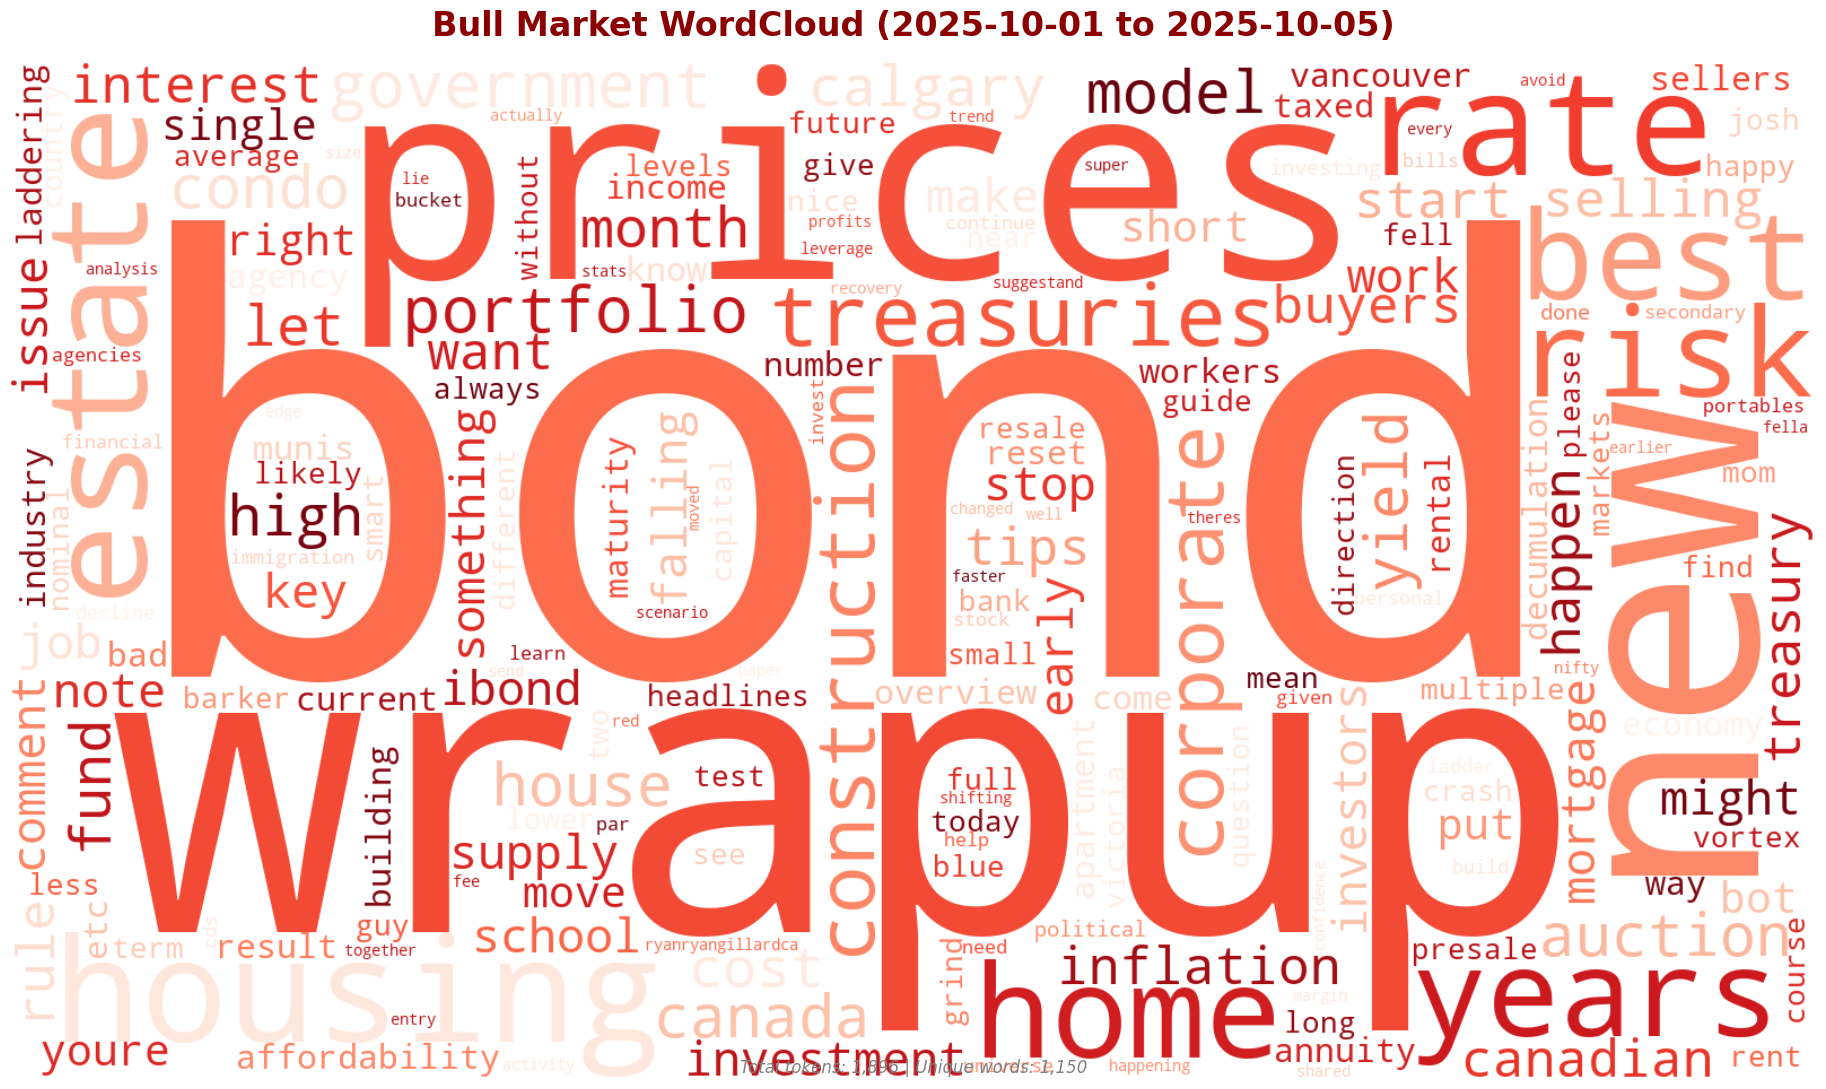


✅ 상승장 워드클라우드 생성 완료!


In [10]:
# ============================================================
# 셀 8: 상승장 워드클라우드 생성 (Red Theme)
# ============================================================

print("🎨 상승장 워드클라우드 생성 중...\n")

# stopwords 적용하여 필터링
bull_filtered_tokens = [word for word in bull_tokens if word not in stopwords_final]

print(f"원본 토큰 수: {len(bull_tokens):,}개")
print(f"필터링 후 토큰 수: {len(bull_filtered_tokens):,}개")
print(f"제거된 토큰 수: {len(bull_tokens) - len(bull_filtered_tokens):,}개")
print(f"고유 단어 수: {len(set(bull_filtered_tokens)):,}개")

# 데이터 충분성 검증
if len(bull_filtered_tokens) < 50:
    print("\n⚠️ 경고: 필터링 후 단어가 너무 적습니다.")
    print("   워드클라우드 품질이 낮을 수 있습니다.")
    print("   stopwords 설정을 완화하는 것을 권장합니다.")

# 워드클라우드용 텍스트 준비
bull_text_for_cloud = ' '.join(bull_filtered_tokens)

# 워드클라우드 생성 (빨간색 테마)
wordcloud_bull = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Reds',  # 빨간색 계열
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10,
    collocations=False
).generate(bull_text_for_cloud)

# 시각화
fig, ax = plt.subplots(figsize=(20, 11))
ax.imshow(wordcloud_bull, interpolation='bilinear')
ax.axis('off')
ax.set_title(
    'Bull Market WordCloud (2025-10-01 to 2025-10-05)',
    fontsize=24,
    fontweight='bold',
    pad=20,
    color='darkred'
)

info_text = f'Total tokens: {len(bull_filtered_tokens):,} | Unique words: {len(set(bull_filtered_tokens)):,}'
fig.text(0.5, 0.02, info_text, ha='center', fontsize=12, style='italic', color='gray')

plt.tight_layout()
plt.show()

print("\n✅ 상승장 워드클라우드 생성 완료!")

🎨 하락장 워드클라우드 생성 중...

원본 토큰 수: 11,190개
필터링 후 토큰 수: 10,282개
제거된 토큰 수: 908개
고유 단어 수: 4,102개


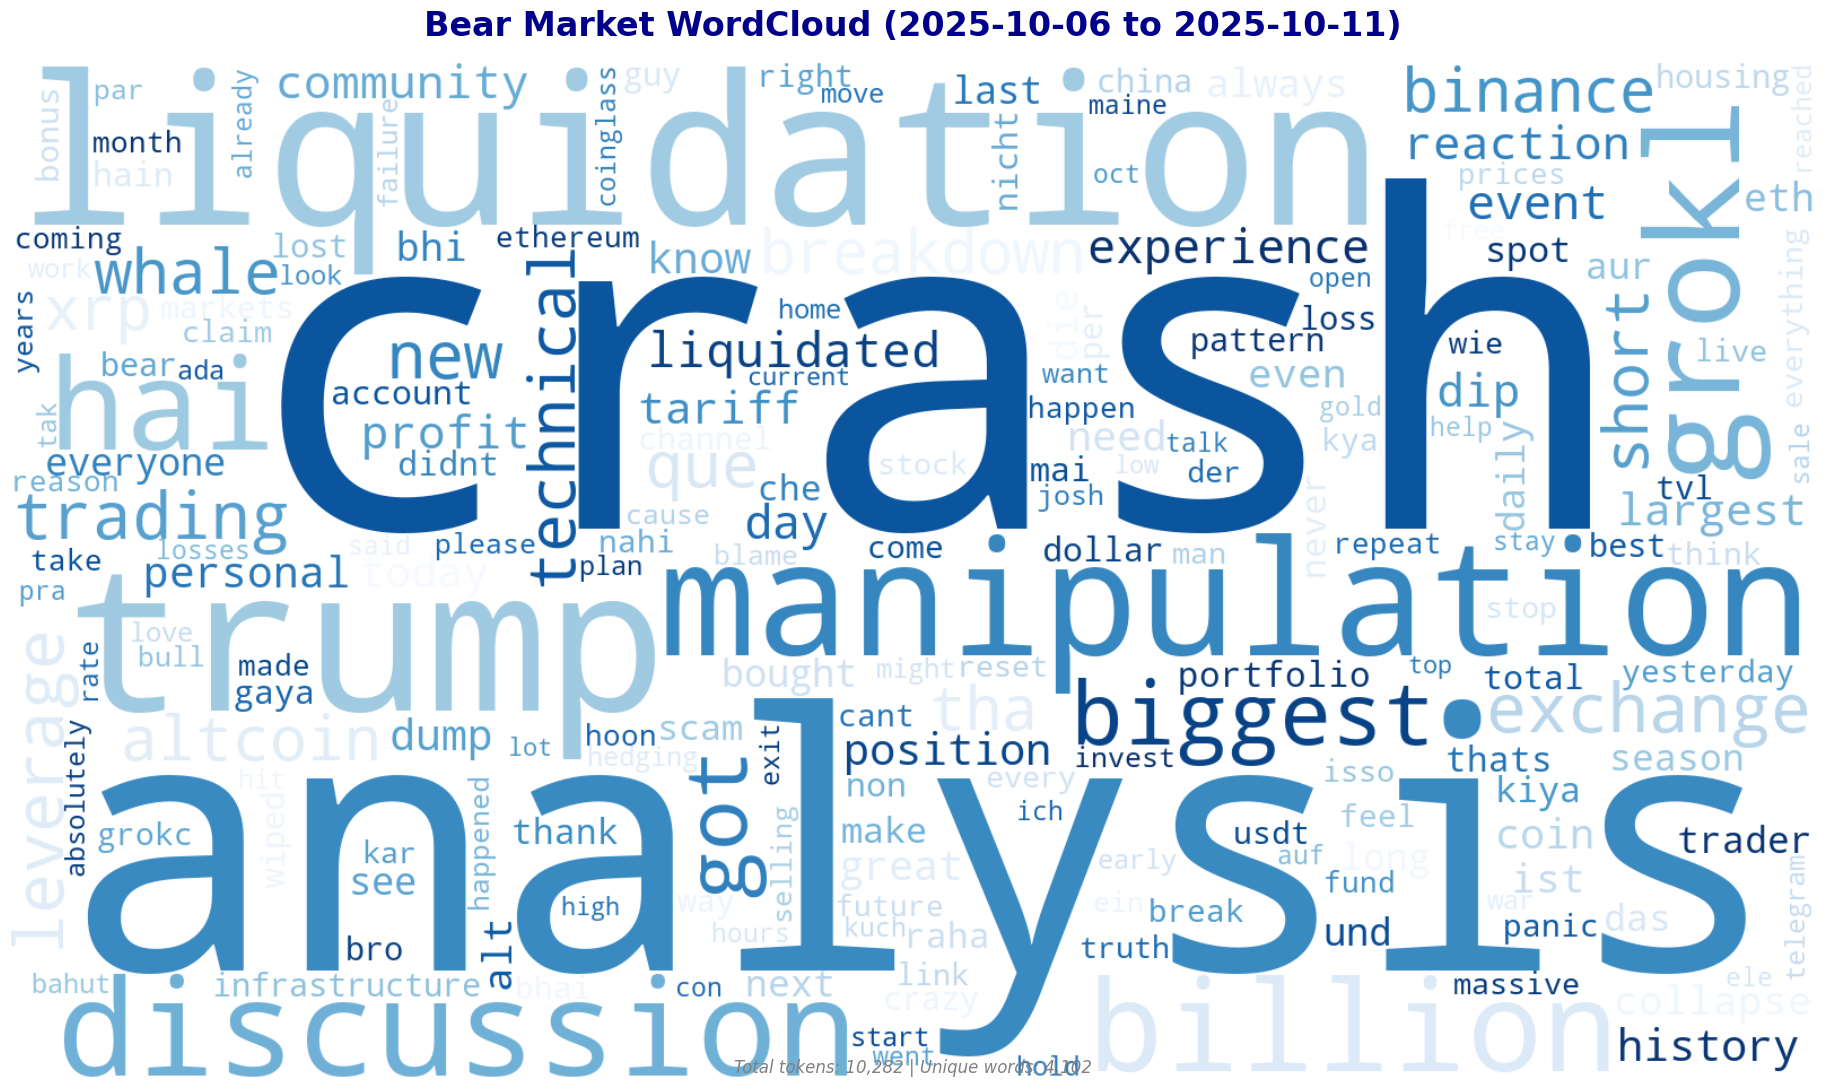


✅ 하락장 워드클라우드 생성 완료!


In [11]:
# ============================================================
# 셀 9: 하락장 워드클라우드 생성 (Blue Theme)
# ============================================================

print("🎨 하락장 워드클라우드 생성 중...\n")

# stopwords 적용하여 필터링
bear_filtered_tokens = [word for word in bear_tokens if word not in stopwords_final]

print(f"원본 토큰 수: {len(bear_tokens):,}개")
print(f"필터링 후 토큰 수: {len(bear_filtered_tokens):,}개")
print(f"제거된 토큰 수: {len(bear_tokens) - len(bear_filtered_tokens):,}개")
print(f"고유 단어 수: {len(set(bear_filtered_tokens)):,}개")

# 데이터 충분성 검증
if len(bear_filtered_tokens) < 50:
    print("\n⚠️ 경고: 필터링 후 단어가 너무 적습니다.")
    print("   워드클라우드 품질이 낮을 수 있습니다.")
    print("   stopwords 설정을 완화하는 것을 권장합니다.")

# 워드클라우드용 텍스트 준비
bear_text_for_cloud = ' '.join(bear_filtered_tokens)

# 워드클라우드 생성 (파란색 테마)
wordcloud_bear = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Blues',  # 파란색 계열
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10,
    collocations=False
).generate(bear_text_for_cloud)

# 시각화
fig, ax = plt.subplots(figsize=(20, 11))
ax.imshow(wordcloud_bear, interpolation='bilinear')
ax.axis('off')
ax.set_title(
    'Bear Market WordCloud (2025-10-06 to 2025-10-11)',
    fontsize=24,
    fontweight='bold',
    pad=20,
    color='darkblue'
)

info_text = f'Total tokens: {len(bear_filtered_tokens):,} | Unique words: {len(set(bear_filtered_tokens)):,}'
fig.text(0.5, 0.02, info_text, ha='center', fontsize=12, style='italic', color='gray')

plt.tight_layout()
plt.show()

print("\n✅ 하락장 워드클라우드 생성 완료!")

In [12]:
# ============================================================
# 셀 10: 두 워드클라우드 비교용 보조표
# ============================================================

print("📊 상승장 vs 하락장 비교 분석\n")

# 필터링된 토큰의 빈도 계산
bull_filtered_freq = Counter(bull_filtered_tokens)
bear_filtered_freq = Counter(bear_filtered_tokens)

# ============================================================
# 상승장 Top 30 (교집합 제외)
# ============================================================
print("📈 상승장 특징 단어 Top 30 (교집합 제외)")
print("="*80)

bull_top30 = bull_filtered_freq.most_common(30)
bull_top30_df = pd.DataFrame(bull_top30, columns=['단어', '빈도'])
bull_top30_df['순위'] = range(1, len(bull_top30_df) + 1)
bull_top30_df['비율(%)'] = (bull_top30_df['빈도'] / len(bull_filtered_tokens) * 100).round(2)
bull_top30_df = bull_top30_df[['순위', '단어', '빈도', '비율(%)']]

display(bull_top30_df)

# ============================================================
# 하락장 Top 30 (교집합 제외)
# ============================================================
print("\n📉 하락장 특징 단어 Top 30 (교집합 제외)")
print("="*80)

bear_top30 = bear_filtered_freq.most_common(30)
bear_top30_df = pd.DataFrame(bear_top30, columns=['단어', '빈도'])
bear_top30_df['순위'] = range(1, len(bear_top30_df) + 1)
bear_top30_df['비율(%)'] = (bear_top30_df['빈도'] / len(bear_filtered_tokens) * 100).round(2)
bear_top30_df = bear_top30_df[['순위', '단어', '빈도', '비율(%)']]

display(bear_top30_df)

# ============================================================
# 독점 단어 분석
# ============================================================
print("\n독점 단어 분석 (한쪽에만 등장하는 단어)")
print("="*80)

bull_only_words = set(bull_filtered_tokens) - set(bear_filtered_tokens)
bear_only_words = set(bear_filtered_tokens) - set(bull_filtered_tokens)

print(f"\n상승장 독점 단어: {len(bull_only_words):,}개")
print(f"하락장 독점 단어: {len(bear_only_words):,}개")
print(f"공통 단어: {len(set(bull_filtered_tokens) & set(bear_filtered_tokens)):,}개")

# 상승장 독점 단어 Top 10
print("\n[상승장 독점 단어 Top 10]")
bull_only_freq = {word: bull_filtered_freq[word] for word in bull_only_words}
bull_only_top10 = sorted(bull_only_freq.items(), key=lambda x: x[1], reverse=True)[:10]

if bull_only_top10:
    bull_only_df = pd.DataFrame(bull_only_top10, columns=['단어', '빈도'])
    bull_only_df['순위'] = range(1, len(bull_only_df) + 1)
    display(bull_only_df[['순위', '단어', '빈도']])
else:
    print("독점 단어 없음")

# 하락장 독점 단어 Top 10
print("\n[하락장 독점 단어 Top 10]")
bear_only_freq = {word: bear_filtered_freq[word] for word in bear_only_words}
bear_only_top10 = sorted(bear_only_freq.items(), key=lambda x: x[1], reverse=True)[:10]

if bear_only_top10:
    bear_only_df = pd.DataFrame(bear_only_top10, columns=['단어', '빈도'])
    bear_only_df['순위'] = range(1, len(bear_only_df) + 1)
    display(bear_only_df[['순위', '단어', '빈도']])
else:
    print("독점 단어 없음")

# ============================================================
# 전체 요약 통계
# ============================================================
print("\n전체 분석 요약")
print("="*80)

summary_data = {
    '항목': [
        '데이터 행 수',
        '전체 토큰 수',
        '필터링 후 토큰 수',
        '고유 단어 수',
        '독점 단어 수',
        '평균 단어 길이'
    ],
    '상승장': [
        f"{len(df_up):,}",
        f"{len(bull_tokens):,}",
        f"{len(bull_filtered_tokens):,}",
        f"{len(set(bull_filtered_tokens)):,}",
        f"{len(bull_only_words):,}",
        f"{np.mean([len(w) for w in bull_filtered_tokens]):.1f}자"
    ],
    '하락장': [
        f"{len(df_down):,}",
        f"{len(bear_tokens):,}",
        f"{len(bear_filtered_tokens):,}",
        f"{len(set(bear_filtered_tokens)):,}",
        f"{len(bear_only_words):,}",
        f"{np.mean([len(w) for w in bear_filtered_tokens]):.1f}자"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n✅ 모든 분석이 완료되었습니다!")
print("\n💡 분석 결과 해석:")
print("   - 워드클라우드에서 큰 단어일수록 자주 언급된 단어입니다.")
print("   - 교집합 단어를 제거하여 각 시장의 특징적인 단어만 표시했습니다.")
print("   - 독점 단어는 한쪽 시장에만 나타나는 고유한 키워드입니다.")

📊 상승장 vs 하락장 비교 분석

📈 상승장 특징 단어 Top 30 (교집합 제외)


,순위,단어,빈도,비율(%)
0,1,bonds,24,1.27
1,2,bond,23,1.21
2,3,wrapup,17,0.90
3,4,prices,16,0.84
4,5,housing,14,0.74
5,6,estate,13,0.69
6,7,new,12,0.63
7,8,years,10,0.53
8,9,best,10,0.53
9,10,treasuries,10,0.53



📉 하락장 특징 단어 Top 30 (교집합 제외)


,순위,단어,빈도,비율(%)
0,1,crash,172,1.67
1,2,analysis,95,0.92
2,3,trump,59,0.57
3,4,manipulation,54,0.53
4,5,liquidation,50,0.49
5,6,discussion,48,0.47
6,7,grokl,45,0.44
7,8,hai,43,0.42
8,9,biggest,39,0.38
9,10,billion,37,0.36



독점 단어 분석 (한쪽에만 등장하는 단어)

상승장 독점 단어: 590개
하락장 독점 단어: 3,542개
공통 단어: 560개

[상승장 독점 단어 Top 10]


,순위,단어,빈도
0,1,wrapup,17
1,2,construction,9
2,3,model,8
3,4,treasury,6
4,5,calgary,6
5,6,tips,6
6,7,corporate,5
7,8,falling,5
8,9,auction,4
9,10,maturity,4



[하락장 독점 단어 Top 10]


,순위,단어,빈도
0,1,trump,59
1,2,manipulation,54
2,3,liquidation,50
3,4,discussion,48
4,5,grokl,45
5,6,hai,43
6,7,biggest,39
7,8,billion,37
8,9,got,37
9,10,que,32



전체 분석 요약


,항목,상승장,하락장
0,데이터 행 수,80,"1,079"
1,전체 토큰 수,"2,126","11,190"
2,필터링 후 토큰 수,"1,896","10,282"
3,고유 단어 수,"1,150","4,102"
4,독점 단어 수,590,"3,542"
5,평균 단어 길이,6.4자,5.8자



✅ 모든 분석이 완료되었습니다!

💡 분석 결과 해석:
   - 워드클라우드에서 큰 단어일수록 자주 언급된 단어입니다.
   - 교집합 단어를 제거하여 각 시장의 특징적인 단어만 표시했습니다.
   - 독점 단어는 한쪽 시장에만 나타나는 고유한 키워드입니다.
